In [7]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import math
import matplotlib
import seaborn as sns


# read data from csv file
original = pd.read_csv('autos.csv', sep=',', header=0, encoding='cp1252')
original = original.head(1000)

# Check data information
original.info()

# Check data statistics
original.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
dateCrawled            1000 non-null object
name                   1000 non-null object
seller                 1000 non-null object
offerType              1000 non-null object
price                  1000 non-null int64
abtest                 1000 non-null object
vehicleType            882 non-null object
yearOfRegistration     1000 non-null int64
gearbox                938 non-null object
powerPS                1000 non-null int64
model                  949 non-null object
kilometer              1000 non-null int64
monthOfRegistration    1000 non-null int64
fuelType               908 non-null object
brand                  1000 non-null object
notRepairedDamage      806 non-null object
dateCreated            1000 non-null object
nrOfPictures           1000 non-null int64
postalCode             1000 non-null int64
lastSeen               1000 non-null object
dtypes: int64(7), object(1

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.0,1000.000000
mean,5755.082000,2002.76300,111.198000,125015.000000,5.951000,0.0,50072.922000
std,8648.759095,29.35552,71.143434,40629.737269,3.774234,0.0,25873.721049
min,0.000000,1111.00000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1200.000000,1999.00000,71.000000,100000.000000,3.000000,0.0,29656.250000
50%,2994.000000,2004.00000,105.000000,150000.000000,6.000000,0.0,49587.500000
75%,7500.000000,2009.00000,150.000000,150000.000000,9.000000,0.0,69683.500000
max,139997.000000,2018.00000,510.000000,150000.000000,12.000000,0.0,99974.000000


['vehicleType', 'gearbox', 'model', 'fuelType', 'brand', 'notRepairedDamage']


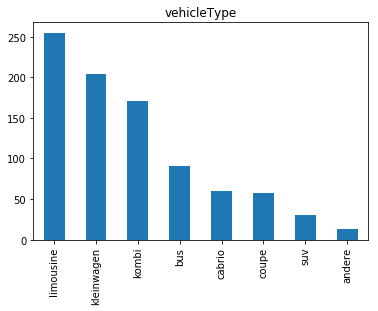

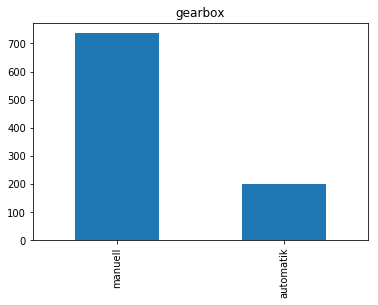

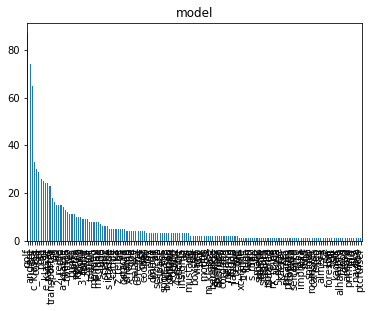

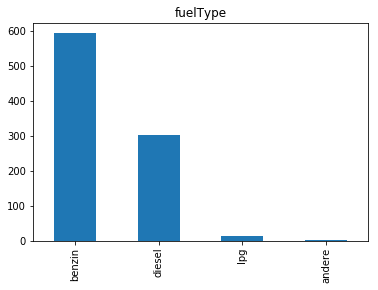

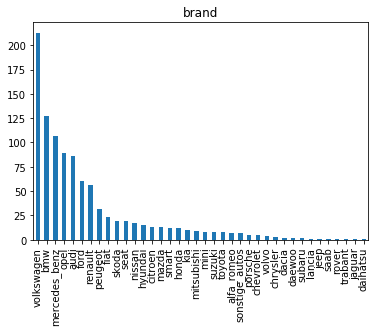

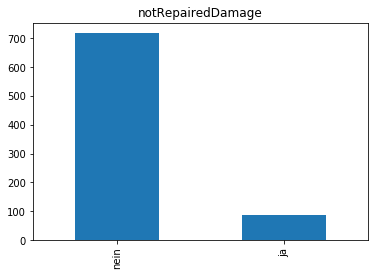

In [8]:

# Restructuring -> Vertical Decomposition
# drop low impact data on price
original.drop(['seller', 'offerType', 'abtest', 'dateCrawled', 'nrOfPictures', 'lastSeen', 'postalCode', 'dateCreated'], axis='columns', inplace=True)


# Remove unusable data(redundant data)
data = original.drop_duplicates(['name','price','vehicleType','yearOfRegistration'
                         ,'gearbox','powerPS','model','kilometer','monthOfRegistration','fuelType'
                         ,'notRepairedDamage'])



category_feature = [col for col in data.columns if data[col].dtypes == 'object' and col != 'name']
print(category_feature)

for col in category_feature:
    data[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.show()
    



['price', 'yearOfRegistration', 'powerPS', 'kilometer', 'monthOfRegistration']


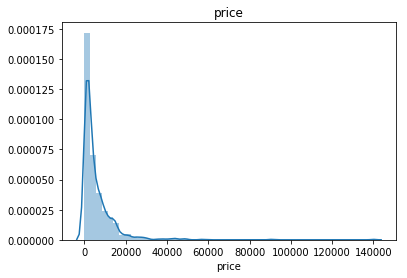

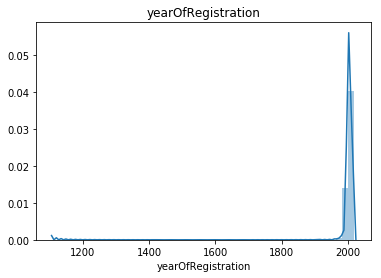

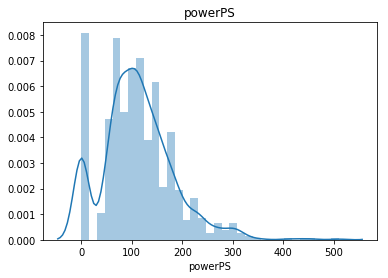

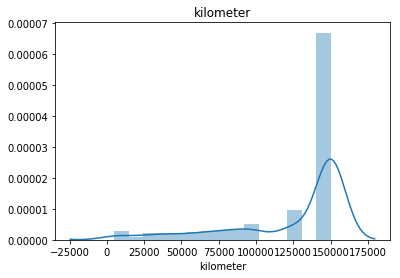

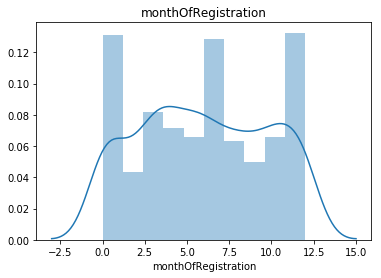

In [9]:

numerical_feature = [col for col in data.columns if data[col].dtypes == 'int64']
print(numerical_feature)

for col in numerical_feature:
    sns.distplot(data.loc[original[col].notnull(), col])
    plt.title(col)
    plt.show()


# Remove the outliers and wrong data
data = data[
        (data.yearOfRegistration <= 2019)
      & (data.yearOfRegistration >= 1950)
      & (data.price >= 100)
      & (data.price <= 80000)
      & (data.powerPS >= 10)
      & (data.powerPS <= 400)]



In [10]:

# Missing data
data.isnull().sum()

# 'model' of car
data = data[data['model'].notnull()]

# Replace null with others
# Replace with the most value according to model type.
# value_counts() --> 맨 위 최빈값.
# 모델 종류를 다 돌아가면서 VehicleType, fuleType, gearbox 중 missing 값인 경우, 해당 모델의 최빈값을 가져와 채움.

for i in range(len(data['model'].unique())) :
    data["vehicleType"].fillna(data.vehicleType[data["model"]==data['model'].unique()[i]].value_counts().index[0], inplace=True)
    data["fuelType"].fillna(data.fuelType[data["model"]==data['model'].unique()[i]].value_counts().index[0], inplace=True)
    data["gearbox"].fillna(data.gearbox[data["model"]==data['model'].unique()[i]].value_counts().index[0], inplace=True)

# null in 'notRepairedDamage' is one of the deciding factors for price prediction.
# -> replace null with 'not-declared'
data["notRepairedDamage"].fillna(value='not-declared', inplace=True)

# Check the misting data is processed.
print(data.isnull().sum())
print(len(data))



name                   0
price                  0
vehicleType            0
yearOfRegistration     0
gearbox                0
powerPS                0
model                  0
kilometer              0
monthOfRegistration    0
fuelType               0
brand                  0
notRepairedDamage      0
dtype: int64
826


In [11]:
# columns that value is string
les = {}


# label encoder
# encode string columns to 0~k-1 labels
for l in category_feature:
    les[l] = preprocessing.LabelEncoder()
    les[l].fit(data[l].astype(str))
    tr = les[l].transform(data[l].astype(str))
    data.loc[:, l + '_encode'] = pd.Series(tr, index=data.index)

# extract only necessary columns to analysis
labeled = data[ ['price'
                ,'yearOfRegistration'
                ,'powerPS'
                ,'kilometer'
                ,'monthOfRegistration']
                + [x+"_encode" for x in category_feature]]


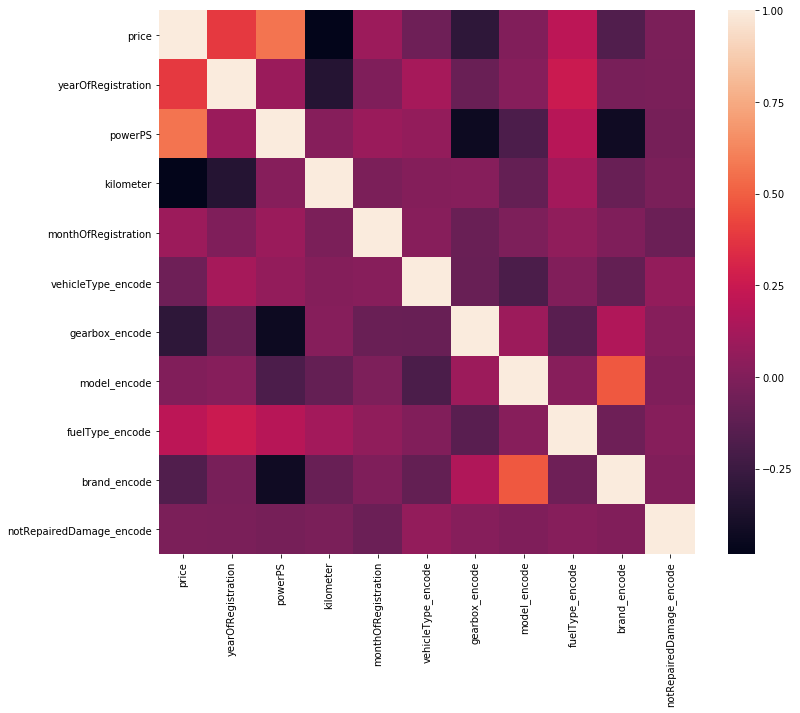

In [12]:

# correlation
# calculate the correlation matrix
corr = labeled.corr()
# adjust matrix size to (12, 10)
plt.subplots( figsize =( 12 , 10 ) )
# plot the correlation heatmap
sns.heatmap(corr,
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [13]:

# Split X and Y
# Y --> price column
# X --> data without price column
Y = labeled['price']
X = labeled.drop(['price'], axis=1, inplace=False)

# standardization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scale = scaler.fit_transform(X)
X_scale = pd.DataFrame(X_scale, columns = X.columns)
print(X_scale)
print(Y)

     yearOfRegistration   powerPS  kilometer  monthOfRegistration  \
0              0.021294  0.666119  -0.020019             0.481286   
1             -0.411228 -0.889207   0.625907            -0.068945   
2              0.597991 -0.995252  -0.924316             0.206170   
3             -1.276272 -0.412005   0.625907             1.031518   
4              0.021294 -0.288286   0.625907             0.481286   
5              1.463035 -0.005499  -2.474539             0.481286   
6             -0.843750 -0.429679   0.625907            -1.719640   
7              0.021294 -0.358982   0.625907             1.581749   
8              0.165469  0.259613   0.625907             1.581749   
9             -1.276272 -0.182241   0.625907             1.306633   
10             0.021294  0.100546   0.625907            -1.169409   
11             1.030513  1.143321  -1.441057            -0.894293   
12             1.751383 -1.154319   0.625907            -1.719640   
13             0.021294 -0.889207 

C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
